the Problem Statement:
We aim to classify network traffic as:

A) Normal: Expected and usual activity.

B) Suspicious: Potential threats or anomalies like unauthorized access, malware communication, unusual traffic patterns.

**Exploratory DATA analysis on raw data.**

In [65]:
#loading the downloaded keggle dataset for the EDA process
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/content/DATA/Internet Firewall Data Set from Kaggle.csv'
df = pd.read_csv(file_path)

# This step is for checking the Datatypes and missing values in Data set.
print("Dataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB
None

Missing Values:
Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0


In [66]:
# Dropping unnecessary columns as I am considering only security analysis)
columns_to_drop = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Converting relevant categorical columns to categories
if 'Action' in df.columns:
    df['Action'] = df['Action'].astype('category')


In [67]:
# Created derived features
df['Bytes Ratio'] = df['Bytes Sent'] / (df['Bytes Received'] + 1e-5)  # To Avoid division by zero
df['Packet Ratio'] = df['pkts_sent'] / (df['pkts_received'] + 1e-5)


In [68]:
# Removed rows with extreme outliers in Bytes and Packets
q_low = df["Bytes"].quantile(0.01)
q_high = df["Bytes"].quantile(0.99)
df = df[(df["Bytes"] >= q_low) & (df["Bytes"] <= q_high)]



In [69]:
# Visualizations for EDA
sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))

#Iam making Visuals of Data set for checking the nature of Data.

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<ipython-input-70-f72e0cba3b0c>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




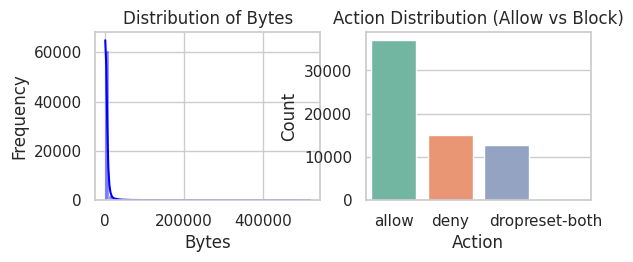

In [70]:
# 1. Distribution of Bytes
plt.subplot(2, 2, 1)
sns.histplot(df['Bytes'], bins=50, kde=True, color='blue')
plt.title('Distribution of Bytes')
plt.xlabel('Bytes')
plt.ylabel('Frequency')

# 2. Action Distribution
if 'Action' in df.columns:
    plt.subplot(2, 2, 2)
    sns.countplot(x='Action', data=df, palette='Set2')
    plt.title('Action Distribution (Allow vs Block)')
    plt.xlabel('Action')
    plt.ylabel('Count')

Text(0, 0.5, 'Frequency')

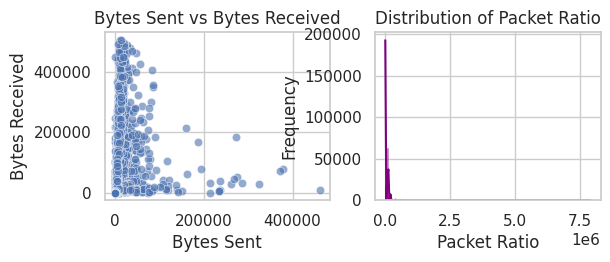

In [71]:
# 3. Bytes Sent vs Bytes Received
plt.subplot(2, 2, 3)
sns.scatterplot(x='Bytes Sent', y='Bytes Received', data=df, alpha=0.6)
plt.title('Bytes Sent vs Bytes Received')
plt.xlabel('Bytes Sent')
plt.ylabel('Bytes Received')

# 4. Distribution of Packet Ratio
plt.subplot(2, 2, 4)
sns.histplot(df['Packet Ratio'], bins=50, kde=True, color='purple')
plt.title('Distribution of Packet Ratio')
plt.xlabel('Packet Ratio')
plt.ylabel('Frequency')


In [72]:

plt.tight_layout()
plt.show()

# Saved cleaned data for Training Machine Learning Model.
cleaned_file_path = "/content/DATA/cleaned_firewall_logs.csv"
df.to_csv(cleaned_file_path, index=False)
cleaned_file_path


<Figure size 640x480 with 0 Axes>

'/content/DATA/cleaned_firewall_logs.csv'

***Bulding A Predictive Machine Learning Model ***

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder


df = pd.read_csv("/content/DATA/cleaned_firewall_logs.csv")

label_encoder = LabelEncoder()
df['Action'] = label_encoder.fit_transform(df['Action'])

# Created derived features for better predictions
df['Bytes Ratio'] = df['Bytes Sent'] / (df['Bytes Received'] + 1e-5)  # This Avoids division by zero
df['Packet Ratio'] = df['pkts_sent'] / (df['pkts_received'] + 1e-5)


In [74]:

# Defining the features (X) and target variable (y)
X = df[['Bytes', 'Packets', 'Bytes Sent', 'Bytes Received', 'Bytes Ratio', 'Packet Ratio']]
y = df['Action']  # 0 for Allow, 1 for Block

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [75]:
# Training the Model ,I used Random Forest algorithm here, which is simple and powerful for this kind of problem.

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [76]:
# Now Model is ready for Predictions, The trained model can now predict whether a given record is normal traffic or suspicious.

y_pred = model.predict(X_test)

In [77]:
# Lets check The accuracy of the mode by Evaluating with classification Report.

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      7394
           1       0.75      0.99      0.86      3009
           2       0.89      0.66      0.76      2566
           3       1.00      0.14      0.25         7

    accuracy                           0.91     12976
   macro avg       0.91      0.69      0.71     12976
weighted avg       0.92      0.91      0.91     12976



In [78]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.91


In [79]:
#Lets Find out which features contribute most to predictions.
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

Feature Importances:
          Feature  Importance
4     Bytes Ratio    0.250161
1         Packets    0.244241
5    Packet Ratio    0.160129
0           Bytes    0.134085
3  Bytes Received    0.112784
2      Bytes Sent    0.098599


In [80]:
# Now the model is ready to Predict on New Data
# Example of predicting new data
new_data = [[1200, 10, 800, 400, 2.0, 1.5]]  # Example data: Bytes, Packets, Bytes Sent, Bytes Received, Bytes Ratio, Packet Ratio
#new_data = [[3961, 21,1438,1889 , 0.76, 1.14]]

new_data_scaled = scaler.transform(new_data)  # Apply the same scaling as training
prediction = model.predict(new_data_scaled)
print(prediction)
# Interpret the result
result = "Suspicious" if prediction[0] == 1 else "Normal"
print(f"The traffic is: {result}")

[0]
The traffic is: Normal


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



**Dashboard to moniter the activity of inbound Traffic Through firewall Data.**

=== The firewall Logs dashboard ===
=== Traffic Overview ===
Total Bytes Transferred: 378728755
Total Packets Transferred: 777379


<ipython-input-81-df81556b764c>:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




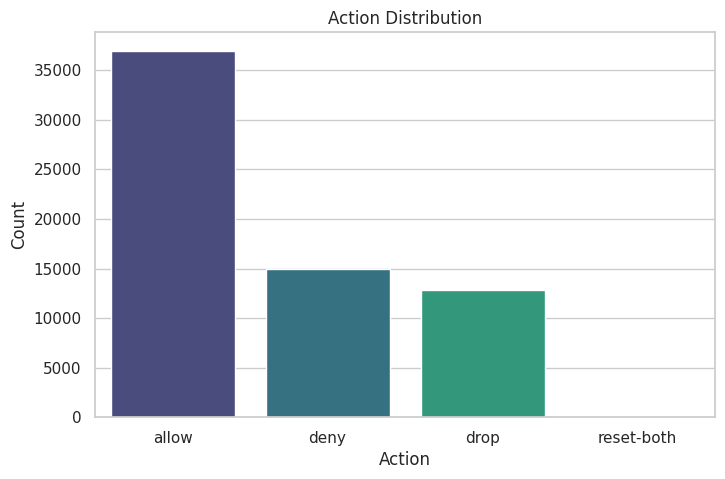

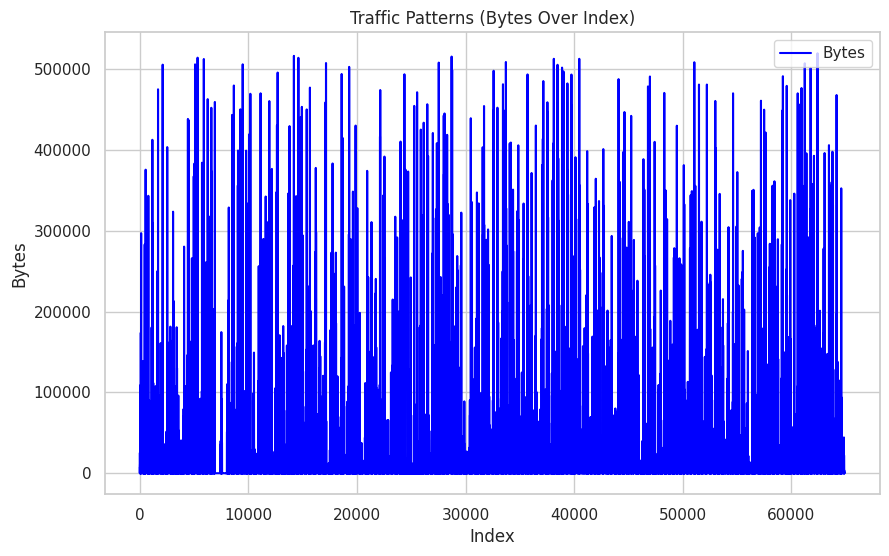


=== Unusual Activities ===
      Action  Bytes  Bytes Sent  Bytes Received  Packets  Elapsed Time (sec)  \
8      allow     70          70               0        1                   5   
52     allow     70          70               0        2                   7   
60     allow     62          62               0        1                   4   
80     allow     94          94               0        1                  30   
84     allow     70          70               0        2                   8   
...      ...    ...         ...             ...      ...                 ...   
64869   deny     62          62               0        1                   0   
64871  allow     70          70               0        2                   8   
64873   drop     70          70               0        1                   0   
64874   drop     70          70               0        1                   0   
64875   drop     70          70               0        1                   0   

       pkts

In [81]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


file_path = '/content/DATA/cleaned_firewall_logs.csv'
df = pd.read_csv(file_path)

print("=== The firewall Logs dashboard ===")

# Traffic Overview
print("=== Traffic Overview ===")
if 'Bytes' in df.columns and 'Packets' in df.columns:
    total_bytes = df['Bytes'].sum()
    total_packets = df['Packets'].sum()
    print(f"Total Bytes Transferred: {total_bytes}")
    print(f"Total Packets Transferred: {total_packets}")
else:
    print("Columns 'Bytes' and 'Packets' not found!")

# Action Distribution Plot
if 'Action' in df.columns:
    action_counts = df['Action'].value_counts()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=action_counts.index, y=action_counts.values, palette="viridis")
    plt.title("Action Distribution")
    plt.xlabel("Action")
    plt.ylabel("Count")
    plt.show()
else:
    print("Column 'Action' not found!")

# Traffic Patterns (Bytes over Index)
if 'Bytes' in df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Bytes'], label='Bytes', color='blue')
    plt.title("Traffic Patterns (Bytes Over Index)")
    plt.xlabel("Index")
    plt.ylabel("Bytes")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Column 'Bytes' not found!")

# Unusual Activities Table
if 'Bytes Ratio' in df.columns and 'Packet Ratio' in df.columns:
    unusual_activities = df[(df['Bytes Ratio'] > 10) | (df['Packet Ratio'] > 10)]
    print("\n=== Unusual Activities ===")
    print(unusual_activities)
else:
    print("Columns 'Bytes Ratio' and 'Packet Ratio' not found!")

